In [1]:
# Ignore warnings (primarily for future deprecation warnings)
import warnings
# warnings.filterwarnings('ignore')

# Raster Analysis
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge

# Vector Analysis
from shapely.geometry import box, mapping, Polygon

# General data manipulation
import geopandas as gpd
import pandas as pd
import numpy as np

# Saving and Accessing Data
import os
import pickle
import json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import folium
import seaborn as sns

# Google Earth Engine
import ee
import geemap

# Machine learning

# Keras
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, Dense, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from importlib import reload
from tqdm import tqdm

c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, os.path.join('src'))

from split_images import split_geometry
import feature_extraction as fe

In [3]:
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [4]:
'''
We begin by preparing some constant variables that will be used throughout the notebook. 
Note that a seed is set for reproducibility.
'''

SEED = 2024
keras.utils.set_random_seed(SEED)
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

In [5]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

In [6]:
dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2023-01-01', '2024-01-01')
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))
    .map(mask_s2_clouds)
)

In [7]:
# geometry_sd = ee.Geometry.Polygon(
#     [[[-70.08239177868184,18.412691062890588],
#       [-69.70542339489278,18.412691062890588],
#       [-69.70542339489278,18.610630760258402],
#       [-70.08239177868184,18.610630760258402]]])

left = -87.2702053
right = -87.1455428
top = 14.1214563
bottom = 14.0312229

geometry_sd = ee.Geometry.Polygon(
    [[[left, bottom],
      [right, bottom],
      [right, top],
      [left, top]]])



sd_cutout = dataset.median().clip(geometry_sd).select(FEATURES)

In [8]:
# Calculate distance between coordinates
def haversine(lat1, lon1, lat2, lon2):
    R = 6378137  # radius of Earth in meters
    phi_1 = np.radians(lat1)
    phi_2 = np.radians(lat2)

    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    meters = R * c  # output distance in meters
    return meters

img_height = haversine(top, left, top, right)
img_width = haversine(top, left, bottom, left)

print(img_height / 23)
print(img_width / 17)

desired_clip_height = 600
desired_clip_width = 600

print(img_height / desired_clip_height)
print(img_width / desired_clip_width)


585.1305139119645
590.8668317968146
22.43000303329197
16.741226900909748


In [9]:
visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

m = geemap.Map()
m.set_center(-87.202438, 14.074999, 13)
m.add_layer(sd_cutout, visualization, 'RGB')
m

Map(center=[14.074999, -87.202438], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sea…

In [10]:
# Create a directory for temporary files if it doesn't exist
temp_dir = "temporary_tegucigalpa"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

output_files = []

output_path = os.path.join(temp_dir, "tegucigalpa_img_0.tif")
if not os.path.exists(output_path):

    # Create dataframe to store image coordinates
    image_coords = pd.DataFrame(columns=["file_name", "x", "y"])


    # Split geometry into smaller subregions (to bypass Earth Engine export limit)
    subgeometries = split_geometry(geometry_sd, x_num_parts=23, y_num_parts=17)

    # Export and download each subregion
    for i, subgeometry in enumerate(subgeometries):
        output_filename = os.path.join(temp_dir, f"tegucigalpa_img_{i}.tif")
        # Convert Shapely geometry to GeoJSON
        geojson_geometry = json.dumps(mapping(subgeometry))
        task = geemap.ee_export_image(sd_cutout, filename=output_filename, region=geojson_geometry, scale=1)
        print(f"Exporting {output_filename}...")

        new_row = pd.DataFrame([{"file_name": output_filename, "x": subgeometry.centroid.x, "y": subgeometry.centroid.y}])

        # Concatenate the new row to the existing DataFrame
        image_coords = pd.concat([image_coords, new_row], ignore_index=True)

        # Stop loop
        break

    # Read and merge downloaded images
    output_files = [os.path.join(temp_dir, f"tegucigalpa_img_{i}.tif") for i in range(len(subgeometries))]

else:
    print("Found existing tegucigalpa_img_#.tif file. Using that instead.")

Found existing tegucigalpa_img_#.tif file. Using that instead.


In [11]:
from keras.preprocessing import image

In [12]:
from tensorflow.keras.applications import EfficientNetB7 as effnet
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_p

In [13]:
image_list = []

for img_path in tqdm(os.listdir("temporary_tegucigalpa")):
    with rasterio.open(os.path.join("temporary_tegucigalpa", img_path)) as src:

        img = src.read([1, 2, 3])  # Read the first three channels (RGB)
        img = np.transpose(img, (1, 2, 0))  # Transpose to (height, width, channels)
        
        # Normalize to 0-255 and convert to uint8
        img = (img - img.min()) / (img.max() - img.min()) * 255
        img = img.astype(np.uint8)

        # Convert to Pillow image
        pil_img = image.array_to_img(img, scale=False)
        pil_img = pil_img.resize((600, 600))  # Resize the image to the desired size
        
        image_list.append(img)

100%|██████████| 391/391 [00:31<00:00, 12.45it/s]


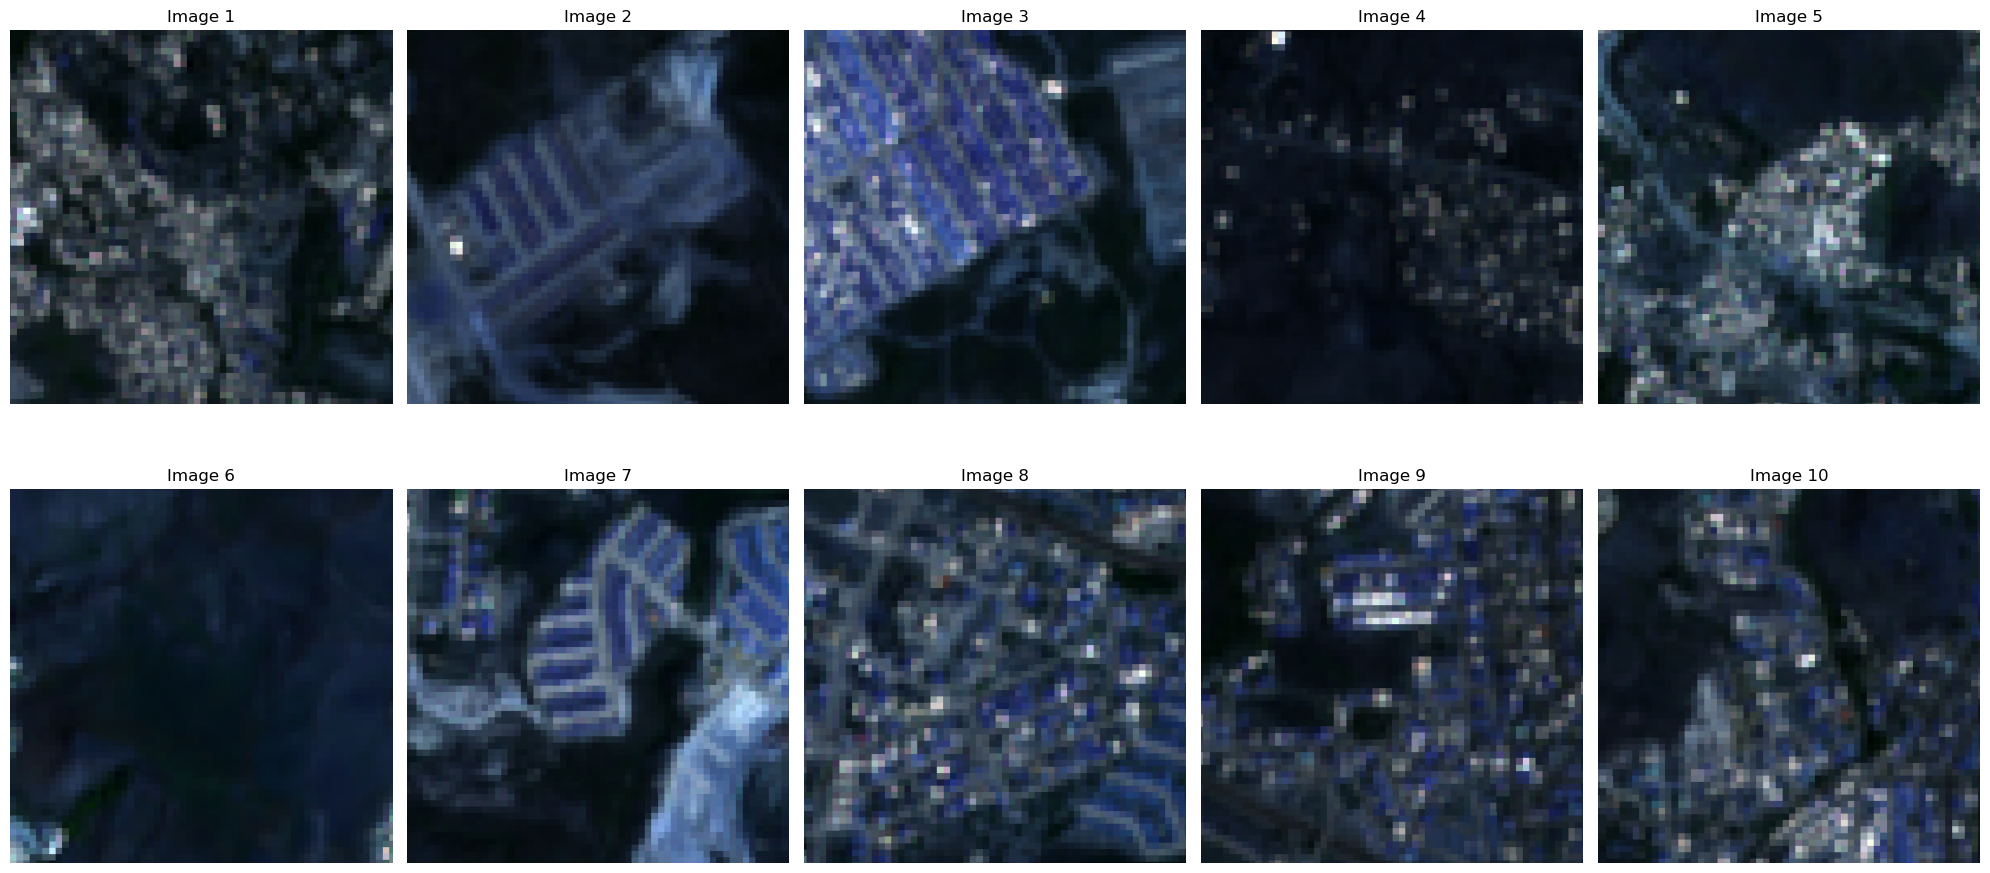

In [14]:
# Show the images in image_list_testing
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(image_list[i-1])
    ax.axis("off")
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

In [15]:
reload(fe)

<module 'feature_extraction' from 'c:\\Users\\juane\\Desktop\\MSc Urban Spatial Science\\Term 3\\Dissertation\\TemporalClusterNet\\src\\feature_extraction.py'>

In [16]:
# Check if effnetb7_tegucigalpa_features.csv exists
if not os.path.exists(os.path.join("output", "effnetb7_tegucigalpa_features.csv")):
    df_effnet_features = fe.extract(effnet, effnet_p, image_list, (600, 600, 3))
    df_effnet_features.to_csv(os.path.join("output", "effnetb7_tegucigalpa_features.csv"), index=True)
else:
    df_effnet_features = pd.read_csv(os.path.join("output", "effnetb7_tegucigalpa_features.csv"), index_col=0)


In [17]:
df_effnet_features.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2550,2551,2552,2553,2554,2555,2556,2557,2558,2559
0,-0.156504,0.010746,0.011965,-0.052384,-0.202820,0.171316,0.055353,0.049675,0.437704,-0.139547,...,-0.092307,0.020802,-0.072811,0.003190,-0.182512,-0.134727,-0.123095,-0.086096,-0.046746,-0.025857
1,0.211039,-0.146875,-0.185208,0.172146,-0.144934,-0.066054,0.025003,-0.059879,-0.089694,-0.152837,...,-0.107619,-0.157131,-0.194431,0.036358,-0.128569,-0.200925,-0.192052,-0.153449,-0.037092,-0.098043
2,0.077118,-0.133391,-0.224904,0.009932,-0.173310,-0.133148,-0.037751,0.013169,0.062851,-0.185376,...,-0.017968,-0.176394,-0.168576,0.060326,-0.028741,-0.173011,-0.118442,-0.100096,-0.176365,-0.006876
3,0.178537,-0.084846,-0.218395,0.090502,-0.182771,0.014650,0.072375,-0.168201,-0.007876,-0.175311,...,0.036964,-0.155327,-0.101521,0.491632,-0.113388,-0.164794,-0.129689,-0.088232,-0.044919,-0.104110
4,0.116446,-0.214584,-0.231605,0.101876,-0.126580,-0.087034,-0.031932,0.031255,0.016028,-0.182875,...,-0.187931,-0.104139,-0.171589,0.058728,-0.072892,-0.178511,-0.154373,0.007413,-0.130539,-0.035035
5,0.018946,-0.124137,0.224306,-0.027442,-0.129347,0.253268,0.214744,0.049632,0.217461,-0.088484,...,0.082760,0.040124,0.007792,0.152469,-0.213362,0.072557,-0.156321,-0.033728,0.132018,0.103771
6,0.084113,-0.197755,-0.224591,0.009312,-0.164902,-0.107919,0.003994,-0.142682,-0.019434,-0.180352,...,-0.071195,-0.192186,-0.174028,0.266552,-0.042328,-0.195251,-0.182111,-0.055519,-0.107517,-0.139987
7,-0.019502,-0.129472,-0.188218,0.011918,-0.118948,-0.074586,0.261690,0.082657,-0.037429,-0.155613,...,-0.079857,-0.097651,-0.152113,0.305650,-0.079889,-0.150653,-0.169044,-0.079528,-0.067703,-0.084767
8,0.184369,-0.150726,-0.236069,0.148808,-0.053850,0.049548,0.108297,0.025013,0.038246,-0.192147,...,-0.044021,-0.081311,-0.120551,0.166821,-0.129895,-0.178352,-0.147376,0.042319,0.049194,-0.087547
9,0.037878,-0.202320,-0.220275,0.083278,-0.156081,-0.030122,0.274640,0.110425,-0.064169,-0.170318,...,-0.048590,-0.180161,-0.114809,0.283412,-0.046761,-0.178220,-0.162627,0.034503,-0.047465,-0.188094


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [19]:
scaler = StandardScaler()
df_effnet_features_pca = scaler.fit_transform(df_effnet_features)

In [20]:
# Use PCA to reduce the dimensionality of the features
pca = PCA(random_state=SEED)
pca.fit(df_effnet_features_pca)

PCA(random_state=2024)

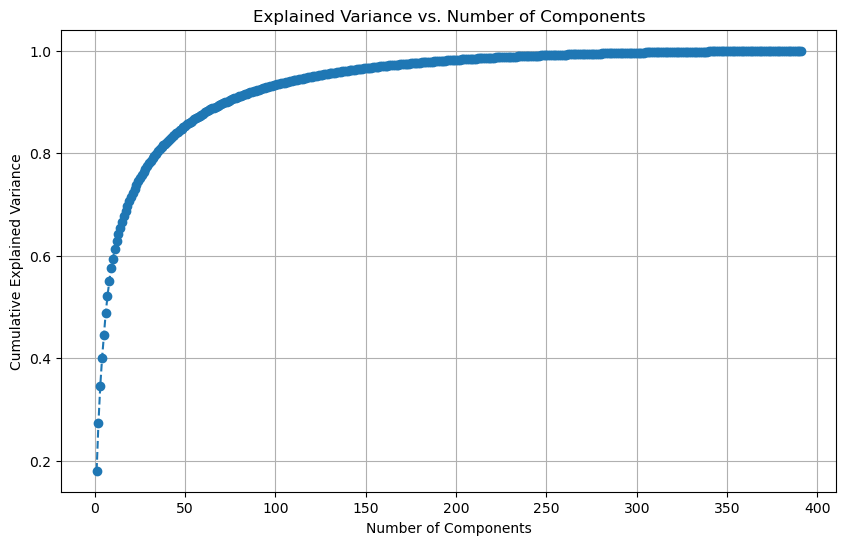

In [21]:
# Plot the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [22]:
# For example, if you want to retain 95% of the variance
n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f'Number of components to retain 95% variance: {n_components}')

Number of components to retain 95% variance: 121


In [23]:
pca = PCA(n_components=2, random_state=SEED)
pca.fit(df_effnet_features_pca)

PCA(n_components=2, random_state=2024)

In [24]:
# Transform the features
df_effnet_features_pca = pd.DataFrame(pca.transform(df_effnet_features_pca), index=df_effnet_features.index)

In [25]:
# Add the image_list items to the DataFrame (line them up)
df_effnet_features_pca["image"] = image_list

In [26]:
# Get the color average of each image
df_effnet_features_pca["color_avg"] = df_effnet_features_pca["image"].apply(lambda x: np.mean(x, axis=(0, 1)))
# Convert the RGB lists to a format suitable for Matplotlib
df_effnet_features_pca['color_avg'] = df_effnet_features_pca['color_avg'].apply(lambda x: [c/255 for c in x])


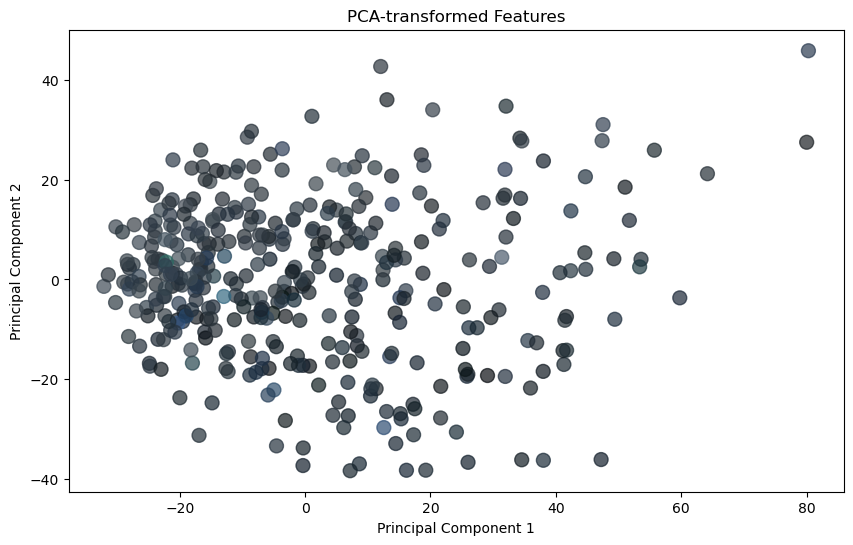

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(
    x=df_effnet_features_pca[0], 
    y=df_effnet_features_pca[1], 
    c=df_effnet_features_pca['color_avg'].tolist(), 
    s=100, 
    edgecolor=None, 
    alpha=0.7
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA-transformed Features")
plt.show()


In [28]:
effnet_features_pca_130 = scaler.fit_transform(df_effnet_features)

In [29]:
pca = PCA(n_components=121, random_state=SEED)
pca.fit(effnet_features_pca_130)
effnet_features_pca_130 = pd.DataFrame(pca.transform(effnet_features_pca_130), index=df_effnet_features.index)

In [30]:
# Cluster the features using KMeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=21, random_state=SEED)
effnet_features_pca_130["cluster"] = kmeans.fit_predict(effnet_features_pca_130)

In [31]:
effnet_features_pca_130_copy = scaler.fit_transform(df_effnet_features)
pca = PCA(n_components=121, random_state=SEED)
pca.fit(effnet_features_pca_130_copy)
effnet_features_pca_130_copy = pd.DataFrame(pca.transform(effnet_features_pca_130_copy), index=df_effnet_features.index)

In [32]:
# Calculate silhouette score
from sklearn.metrics import silhouette_score

sil = []
kmax = 100

for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=SEED).fit(effnet_features_pca_130_copy)
    labels = kmeans.labels_
    sil.append(silhouette_score(effnet_features_pca_130_copy, labels, metric='euclidean'))

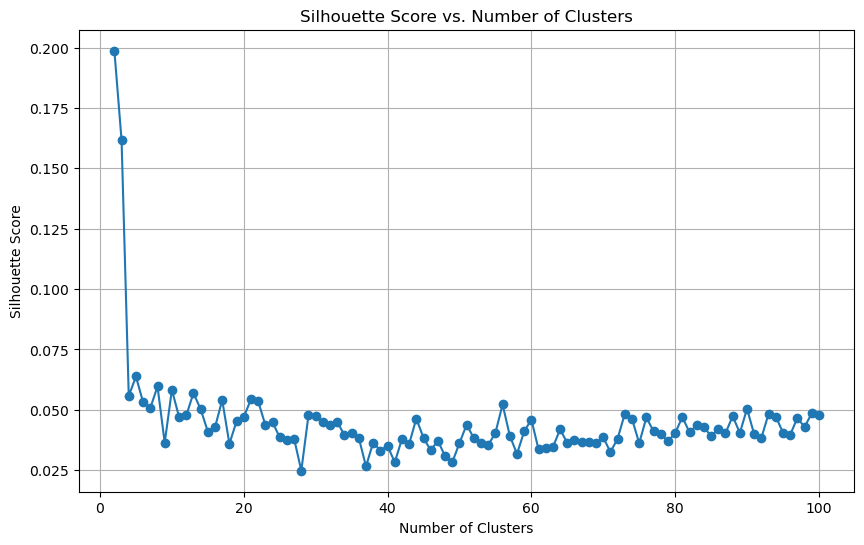

In [33]:
# Plot silhouette score
plt.figure(figsize=(10, 6))
plt.plot(range(2, kmax+1), sil, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

In [34]:
# Create elbow plot
X = effnet_features_pca_130_copy
distorsions = []
for k in range(2, 100):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow curve')

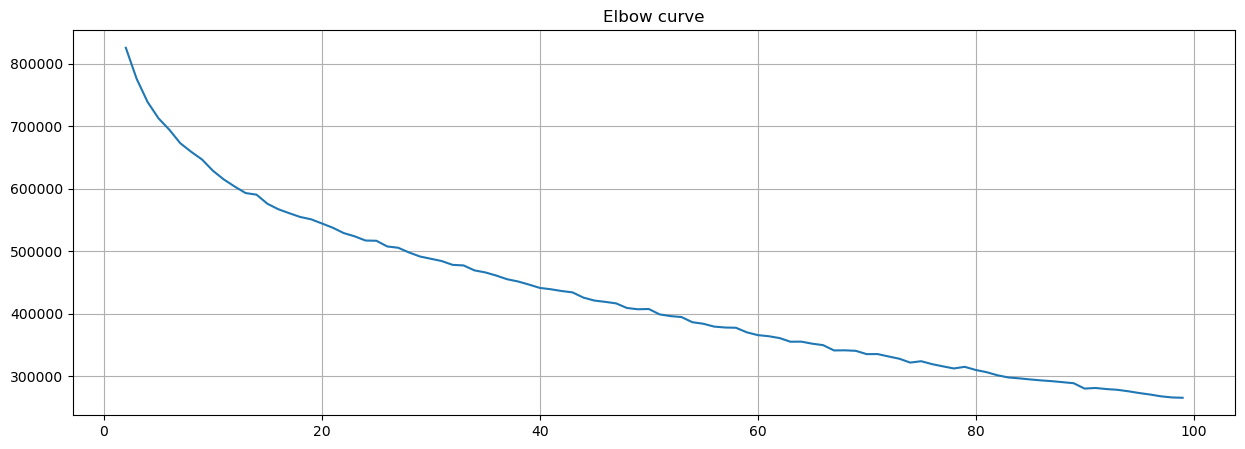

In [35]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 100), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [36]:
effnet_features_pca_130

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,cluster
0,59.776964,-3.682275,0.426752,16.211579,17.373764,49.835173,-18.875282,-0.831195,3.247677,16.831187,...,-1.058311,-1.062135,0.400281,-1.373169,0.414170,0.275484,-0.054149,0.728132,0.286201,20
1,31.892482,22.082135,16.102747,17.150190,-23.294502,19.058210,-23.808556,-19.036410,25.315928,5.555863,...,-0.048757,-0.594399,-1.837077,-1.520556,1.416390,3.482964,-1.471503,0.053412,0.520615,9
2,8.318371,-13.287066,-17.848634,-11.311591,1.856076,-8.284304,-23.619777,13.262593,-7.629145,3.290650,...,-1.993455,-1.738552,0.790499,-0.705443,1.665969,-0.237332,-0.015163,-0.902795,-0.347775,15
3,3.847453,-7.275002,7.070685,3.262815,-11.131392,-15.478371,-2.709546,8.158003,5.105831,7.168328,...,-0.734061,-1.776016,0.085880,1.403144,-2.520525,-1.507581,-0.660409,1.985230,-1.591196,19
4,-5.622150,4.069471,-9.127682,34.740439,-13.571326,-14.654772,-7.125283,9.882870,-10.455734,0.582148,...,-0.788953,0.295180,-1.912479,0.872530,-2.175890,-0.349729,0.552401,-1.090083,-2.274336,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,-12.636182,-17.838461,19.249812,3.079857,5.993671,-14.678335,5.881488,-7.717949,-8.680765,7.007203,...,0.724095,-0.216400,0.469346,-0.726990,0.583802,0.098384,-1.367612,0.053419,0.722406,19
387,34.571953,27.786733,41.769923,-4.773978,-5.835703,16.599257,22.998615,36.342332,-20.113799,3.794025,...,-0.533179,-0.481176,0.404350,-0.213057,0.304448,-0.221626,0.237126,-0.367977,0.302509,16
388,-18.297499,0.215431,20.556041,3.083934,-2.630448,-4.485230,5.488977,-4.009764,-1.303414,0.253618,...,0.458227,-0.109034,-0.275805,0.347828,-0.145738,0.682761,-0.585452,-1.444685,0.048515,1
389,-1.946437,11.976963,16.340728,-17.178122,-5.708642,12.208332,11.530099,-3.823568,7.195962,-1.866936,...,3.597231,1.758661,-0.692393,-3.999241,-3.747158,-1.571898,-0.232208,-0.039725,-2.993916,1


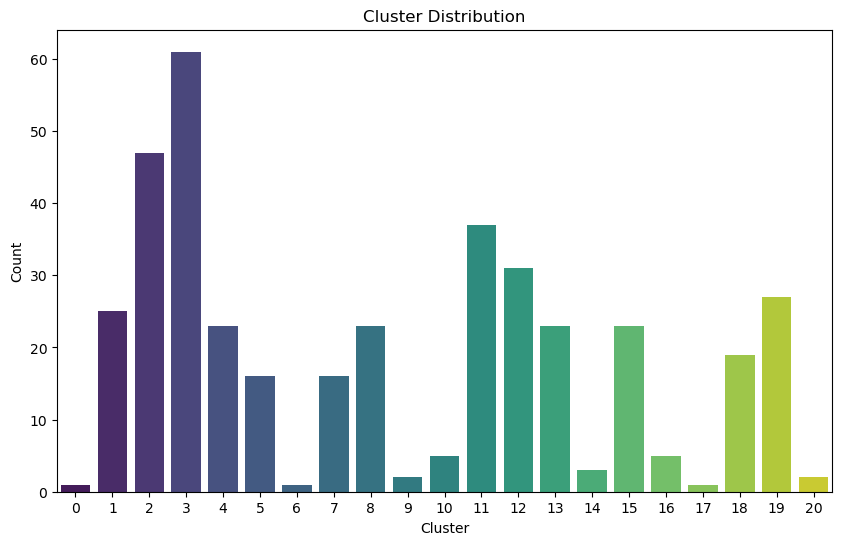

In [37]:
# What is the distribution of clusters?
cluster_counts = effnet_features_pca_130["cluster"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Cluster Distribution")
plt.show()

In [38]:
effnet_features_pca_130["image"] = image_list

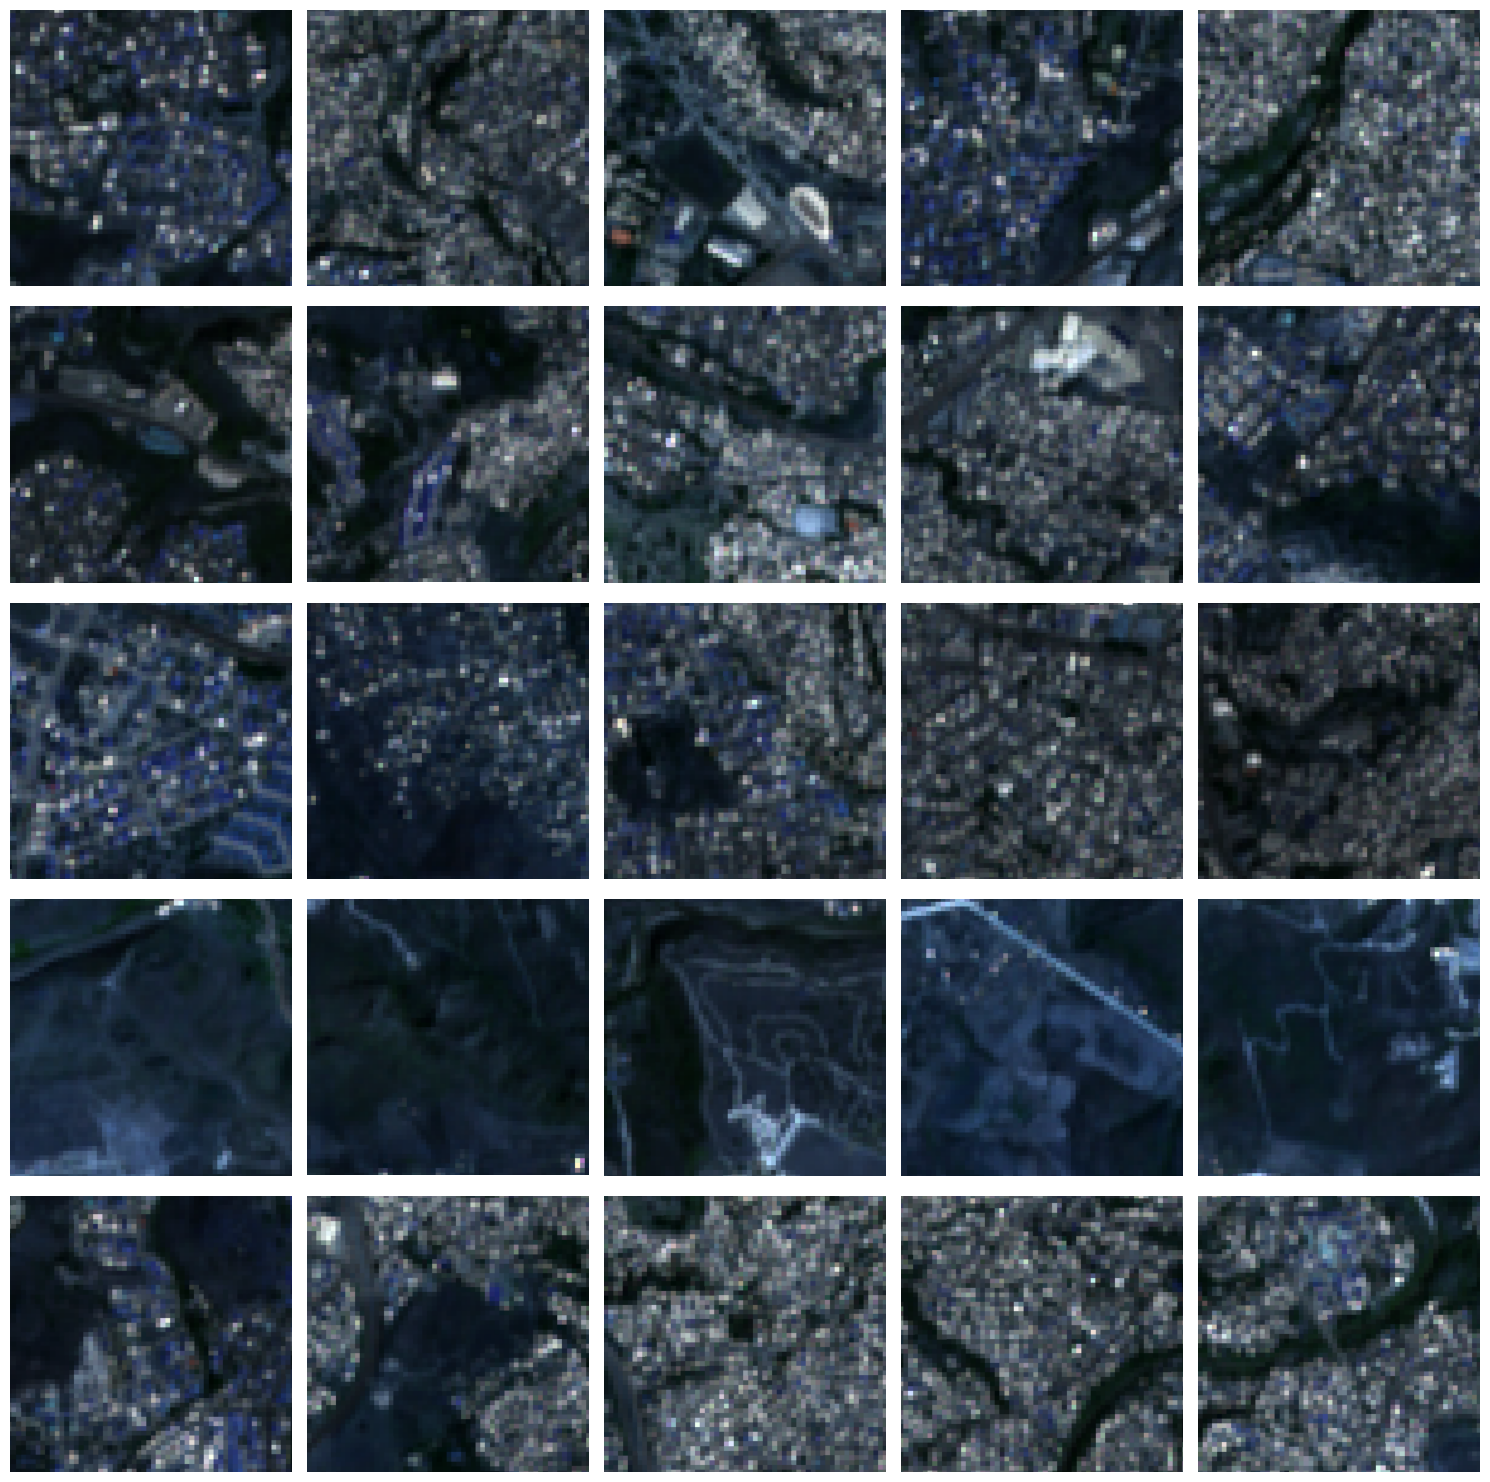

In [39]:

# Filter 5 images for each cluster from 1 to 5
start_cluster = 1
end_cluster = 5
num_images_per_cluster = 5

# Create a plot with 5x5 subplots
fig, axes = plt.subplots(end_cluster - start_cluster + 1, num_images_per_cluster, figsize=(15, 15))

for cluster in range(start_cluster, end_cluster + 1):
    cluster_images = effnet_features_pca_130[effnet_features_pca_130['cluster'] == cluster]['image'].head(num_images_per_cluster)
    for i, img in enumerate(cluster_images):
        axes[cluster - start_cluster, i].imshow(img)
        axes[cluster - start_cluster, i].axis('off')  # Hide axes for a cleaner look

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

In [40]:
# Load in the raster data as rasterio objects and add them to the dataframe

for i, img_path in enumerate(os.listdir("temporary_tegucigalpa")):
    temp_raster = rasterio.open(os.path.join("temporary_tegucigalpa", img_path))
    effnet_features_pca_130.loc[i, "raster"] = temp_raster
    effnet_features_pca_130.loc[i, "raster_path"] = os.path.join("temporary_tegucigalpa", img_path)


In [41]:
# Add a new column titled geometry_i to the dataframe, it is the digits just before the ".tif" in the raster_path
effnet_features_pca_130["geometry_i"] = effnet_features_pca_130["raster_path"].str.extract(r"(\d+)\.tif")

In [42]:
# Create copy of effnet_features_pca_130 with only the cluster and geometry_i columns
cluster_df = effnet_features_pca_130[["cluster", "geometry_i"]]

In [43]:
subgeometries = split_geometry(geometry_sd, x_num_parts=23, y_num_parts=17)

# Export and download each subregion
for i, subgeometry in enumerate(subgeometries):
    # Print the coordinates of the subgeometry
    # Add the subgeometry to the cluster_df based on the geometry_i and i
    cluster_df.loc[cluster_df["geometry_i"] == str(i), "geometry"] = subgeometry

In [44]:
# Convert the cluster_df to a GeoDataFrame
cluster_gdf = gpd.GeoDataFrame(cluster_df, geometry="geometry")

# Add crs to the GeoDataFrame
cluster_gdf.crs = "EPSG:4326"

In [45]:
import matplotlib.colors as mcolors

In [46]:
# Create a new Geodataframe where all rows with the same cluster are join together
cluster_gdf_merged = cluster_gdf.dissolve(by="cluster")

# Make create a column with the cluster number
cluster_gdf_merged["cluster"] = cluster_gdf_merged.index

In [47]:
# Load in the tegucigalpa Precarious Settlements dataset
precario_path = os.path.join("data", "tegucigalpa_PC.zip")
precario_gdf = gpd.read_file(precario_path)

In [48]:
visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

m = geemap.Map()
m.set_center(-87.202438, 14.074999, 13)
m.add_layer(sd_cutout, visualization, 'RGB')

# Generate a colormap with 50 distinct colors
num_clusters = 20
cmap = plt.get_cmap('tab20')  # You can choose other colormaps like 'tab20', 'tab20c', etc.
colors = cmap(np.linspace(0, 1, num_clusters))

# Create a dictionary mapping each cluster number to a color
colormap = {i + 1: mcolors.rgb2hex(colors[i]) for i in range(num_clusters)}

m.add_gdf(cluster_gdf_merged, layer_name='Clusters', fill_colors=list(colormap.values()), style={'fillOpacity': 0.75, 'opacity': 0},
          hover_style={'fillOpacity': 0.25, 'opacity': 1})

m.add_gdf(precario_gdf, layer_name='Precarious Settlements', fill_colors='red', style={'fillOpacity': 0.75, 'opacity': 0})

m

Map(center=[14.074999, -87.202438], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sea…

In [49]:
# Create a set of sample points within the area of interest
n_points = 1000
x = np.random.uniform(left, right, n_points)
y = np.random.uniform(bottom, top, n_points)
points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x, y), crs='EPSG:4326')

# Assign the cluster number to each point based on the cluster it falls within
points['cluster'] = points.apply(lambda x: cluster_gdf_merged.loc[cluster_gdf_merged.contains(x.geometry)].index[0], axis=1)

# Assign whether each point falls within a precarious settlement
points['precario'] = points.apply(lambda x: precario_gdf.contains(x.geometry).any(), axis=1)

In [50]:
# Remove geometry column
points = points.drop(columns='geometry')

In [51]:
unique_clusters = points['cluster'].unique()

# Create a new dataframe to hold the transformed data
points_pivot = pd.DataFrame()

# Retain the "precario" column
points_pivot['precario'] = points['precario']

# Add new columns for each cluster with True/False values
for cluster in unique_clusters:
    points_pivot[cluster] = (points['cluster'] == cluster)

In [52]:
points_pivot

,precario,2,11,8,12,0,18,15,3,20,...,7,19,9,5,4,14,10,16,17,6
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
996,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
997,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
998,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [53]:
# Import precision_score and recall_score from sklearn.metrics
from sklearn.metrics import precision_score, recall_score

In [54]:
# For each cluster, calculate the precision and recall, and store them in a dataframe
precision_recall_df = pd.DataFrame(columns=["cluster", "precision", "recall"])

for cluster in unique_clusters:
    precision = precision_score(points_pivot['precario'], points_pivot[cluster])
    recall = recall_score(points_pivot['precario'], points_pivot[cluster])
    precision_recall_df = pd.concat([precision_recall_df, pd.DataFrame({"cluster": cluster, "precision": precision, "recall": recall}, index=[0])], ignore_index=True)

precision_recall_df

,cluster,precision,recall
0,2,0.000000,0.000000
1,11,0.149425,0.135417
2,8,0.000000,0.000000
3,12,0.098765,0.083333
4,0,0.000000,0.000000
5,18,0.052632,0.031250
6,15,0.033898,0.020833
7,3,0.178808,0.281250
8,20,0.375000,0.031250
9,1,0.138462,0.093750


In [55]:
# Create a subset of the clusters with a Precision score higher than 0.001
high_precision_clusters = precision_recall_df[precision_recall_df['precision'] > 0.001]['cluster'].tolist()
high_precision_clusters

[11, 12, 18, 15, 3, 20, 1, 13, 7, 19, 5, 4, 14, 10]

In [56]:
# Create a new empty dataframe
combinations_df = pd.DataFrame(columns=["combination"])

# Create a list of all possible combinations of clusters
from itertools import combinations

for i in range(1, len(high_precision_clusters) + 1):
    for combination in combinations(high_precision_clusters, i):
        combination = list(combination)

        if len(combination) > 5:
            break

        combinations_df = pd.concat([combinations_df, pd.DataFrame({"combination": [combination]})], ignore_index=True)

combinations_df

,combination
0,[11]
1,[12]
2,[18]
3,[15]
4,[3]
...,...
3467,"[7, 19, 5, 4, 10]"
3468,"[7, 19, 5, 14, 10]"
3469,"[7, 19, 4, 14, 10]"
3470,"[7, 5, 4, 14, 10]"


In [57]:
# For each combination of clusters, calculate the precision and recall
for i, row in tqdm(combinations_df.iterrows(), total=combinations_df.shape[0]):
    combination = row['combination']
    precision = precision_score(points_pivot['precario'], points_pivot[combination].any(axis=1))
    recall = recall_score(points_pivot['precario'], points_pivot[combination].any(axis=1))
    combinations_df.loc[i, "precision"] = precision
    combinations_df.loc[i, "recall"] = recall

# Sort the combinations by precision
combinations_df = combinations_df.sort_values(by="precision", ascending=False)

combinations_df

100%|██████████| 3472/3472 [01:01<00:00, 56.71it/s]


,combination,precision,recall
12,[14],0.625000,0.052083
75,"[20, 14]",0.500000,0.083333
5,[20],0.375000,0.031250
412,"[20, 14, 10]",0.300000,0.093750
104,"[14, 10]",0.272727,0.062500
...,...,...,...
86,"[13, 5]",0.036697,0.041667
330,"[15, 13, 5]",0.035714,0.062500
53,"[15, 13]",0.033898,0.041667
7,[13],0.033898,0.020833


In [58]:
# Calculate the F1 score for each combination
combinations_df["f1_score"] = 2 * (combinations_df["precision"] * combinations_df["recall"]) / (combinations_df["precision"] + combinations_df["recall"])

In [59]:
# Print top 10 with the highest F1 score
combinations_df.sort_values(by="f1_score", ascending=False).head(10)

,combination,precision,recall,f1_score
1991,"[11, 3, 20, 7, 14]",0.182432,0.562500,0.275510
1980,"[11, 3, 20, 1, 14]",0.178683,0.593750,0.274699
1995,"[11, 3, 20, 19, 14]",0.176647,0.614583,0.274419
641,"[11, 3, 20, 14]",0.188976,0.500000,0.274286
3229,"[3, 20, 1, 7, 14]",0.182482,0.520833,0.270270
3258,"[3, 20, 7, 19, 14]",0.179931,0.541667,0.270130
3233,"[3, 20, 1, 19, 14]",0.176282,0.572917,0.269608
2002,"[11, 3, 20, 14, 10]",0.182836,0.510417,0.269231
1276,"[3, 20, 7, 14]",0.196172,0.427083,0.268852
1265,"[3, 20, 1, 14]",0.189655,0.458333,0.268293


In [60]:
# Plot the top combinations by F1 score alongside the precarious settlements
m = geemap.Map()

m.set_center(-87.202438, 14.074999, 13)

m.add_gdf(precario_gdf, layer_name='Precarious Settlements', fill_colors='red', style={'fillOpacity': 0.75, 'opacity': 0})

cluster_colors = list(colormap.values())

for i, row in combinations_df.sort_values(by="f1_score", ascending=False).head(10).iterrows():
    combination = row['combination']
    cluster_gdf_subset = cluster_gdf_merged[cluster_gdf_merged.index.isin(combination)]
    m.add_gdf(cluster_gdf_subset, layer_name=f'Combination {i+1}', fill_colors=cluster_colors, style={'fillOpacity': 0.75, 'opacity': 0})

m

Map(center=[14.074999, -87.202438], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sea…